In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import numpy as np
import os

from astropy.time import Time
from matplotlib import gridspec
from scipy.signal import savgol_filter as savitzky_golay

In [2]:
filename = 'data/iktausRAW_blue_red_channels.tscat'
tsformat = 'mjd'
epoch = 0.

In [3]:
import hart_io as io
# read input data assuming HartRAO format
[header,
 chan_vel,
 timestamps,
 spectra,
 ts_jd] = io.input(filename,
                   epoch=epoch,
                   tsformat=tsformat)
avg_spectra = spectra.mean(axis=0)

In [4]:
# human readable string for information
# timestamps [channel velocities]
print(header)
print('Spectral data size (#ts, #ch) = ({}, {})'.format(timestamps.size, spectra.shape[1]))
[comment, head_line] = header.strip().split('\n')

IKTAU        OH1612 time series of intensities F from iktaus.sf85
MJD, 17.368, 50.373

Spectral data size (#ts, #ch) = (205, 2)


In [5]:
# 0 - blue spectrum
# 1 - red spectrum
spectrum = spectra[:, 0]
velocity = chan_vel[0]
jd_datetime = ts_jd.datetime

### Fit, detrend and remove outliers recursively

In [6]:
def show_fit(x,
             raw_y,
             clean_y,
             outliers,
             trend = None):

    fig, ax = plt.subplots(nrows=1, ncols=1,
                           figsize=(17,3),
                           facecolor='white')
    ax.plot(x, raw_y, 'b.')
    ax.plot(x[outliers], raw_y[outliers], 'r.')
    if trend is not None:
        ax.plot(x, trend, 'k-')
    ax.plot(x[outliers], clean_y[outliers], 'm*')

In [7]:
def fit_curve(data, sigma=3.):
    smoothed_curve = np.empty(data.shape)
    outliers = np.empty(data.shape, dtype=bool)
    
    smoothed_curve = savitzky_golay(data, 21, 3)
    detrended = data - smoothed_curve

    threshold = np.mean(detrended) + sigma*np.std(detrended)
    outliers = np.abs(detrended) > threshold
        
    return smoothed_curve, outliers

In an iterative process a curve is fitted to the data and subtracted from the original to obtain.
This residual is used to identify and remove outliers, after which the cleaned data is used to repeat the process.

In [8]:
debug = False  # show more verbose output to help with development and debug
threshold_deviation = 3.
n_iter = 100  # max number of iterations

In [9]:
done = False
cnt = 0
remove_idx = np.zeros(spectrum.shape, dtype=bool)
clean_data = spectrum.copy()
while not done:
    smoothed_curve, outliers = fit_curve(clean_data, sigma=threshold_deviation)

    if np.nonzero(outliers)[0].size < 1:
        done = True
        break

    clean_data[outliers] = smoothed_curve[outliers]
    remove_idx = (remove_idx | outliers)

    if debug:
        show_fit(timestamps,
                 spectrum,
                 clean_data,
                 remove_idx,
                 trend=smoothed_curve)
    
    cnt += 1
    if cnt > n_iter:
        done = True
        break

### Clean signals

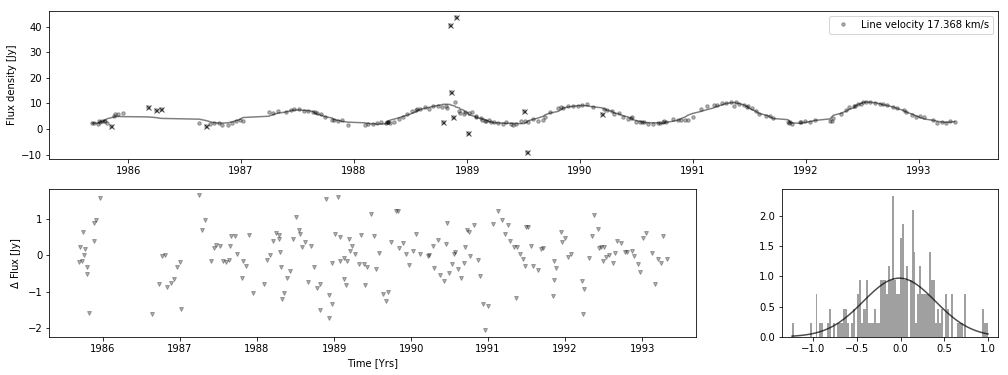

In [10]:
fig= plt.subplots(figsize=(17,6),
                  facecolor='white')
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1])
ax0 = plt.subplot(gs[0,:])
ax0.plot(jd_datetime, spectrum,
         color='k', marker='.', linestyle='none', markersize=7, alpha=0.3,
         label=r'Line velocity {} km/s'.format(velocity))
if sum(remove_idx) > 0:
    ax0.plot(ts_jd[remove_idx].datetime, spectrum[remove_idx],
             color='k', marker='x', linestyle='none', markersize=5, alpha=0.7)
    ax0.plot(ts_jd.datetime, smoothed_curve,
             color='k', marker=',', linestyle='-', markersize=0, alpha=0.5)
ax0.legend(loc=0)
ax0.set_ylabel('Flux density [Jy]')

ax1 = plt.subplot(gs[1, 0])
residual = spectrum[~remove_idx] - smoothed_curve[~remove_idx]
ax1.plot(jd_datetime[~remove_idx], residual,
         color='k', marker='v', linestyle='none', markersize=4, alpha=0.3)
ax1.set_xlabel('Time [Yrs]')
ax1.set_ylabel(r'$\Delta$ Flux [Jy]')

# the histogram of the data to check that sample noise is gaussion (white)
ax2 = plt.subplot(gs[1, 1])
ts = timestamps[~remove_idx]
norm_data = np.apply_along_axis(func1d=lambda x: x/np.max(residual), arr=residual, axis=0)
ax2.hist(norm_data, 100, density=1, facecolor='gray', alpha=0.75)
mean = np.mean(norm_data)
variance = np.var(norm_data)
sigma = np.sqrt(variance)
x = np.linspace(min(norm_data), max(norm_data), 100)
ax2.plot(x, mlab.normpdf(x, mean, sigma),
         color='k', marker=',', linestyle='-', markersize=0, alpha=0.7)

fig_name = os.path.splitext(os.path.basename(filename))[0]
plt.savefig('{}_cleaned.png'.format(fig_name),
            bbox_inches='tight')

plt.show()

The dots in the top graph show the cleaned data over the timeseries with the crosses indicating the discarded outliers.
To evaluate how well the smoothed curve fit the data the residual is shown as triangles in the lower graph.
The histogram of the sampling distribution indicates a reasonable noise like character to the residual with the expected Gaussian distribution.